In [7]:
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2

import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline 


In [8]:
import imutils 

In [9]:
def crop_brain_contour(image, plot=False):
    #convert image to grayscale, and blur it slightly
    #gray = image.astype('uint8')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    #threshold the image, then perform a series of erosions+
    #dilations to remove any small regions of noise 
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh,None, iterations= 2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    #find contours in threshold image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    #find extreme points
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    #crop new image out of the original image using the four extreme points (left, right, top, bottom)
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]: extRight[0]]
    
    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both',
                       top=False, bottom=False, left=False, right=False,
                       labelbottom=False, labeltop=False,labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                       top=False, bottom=False, left=False, right=False,
                       labelbottom=False, labeltop=False, labelleft=False,labelright=False)
        plt.title('Cropped Image')
        
        plt.show()
        
    return new_image

In [5]:
ex_img = cv2.imread('/Users/user/Desktop/brain_tumor_dataset/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

NameError: name 'cv2' is not defined

In [176]:
#load up the data
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '//' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [177]:
augmented_path = '/Users/user/Desktop/Augmented data/'

#augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240,240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 2275
X shape is: (2275, 240, 240, 3)
y shape is: (2275, 1)


In [178]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

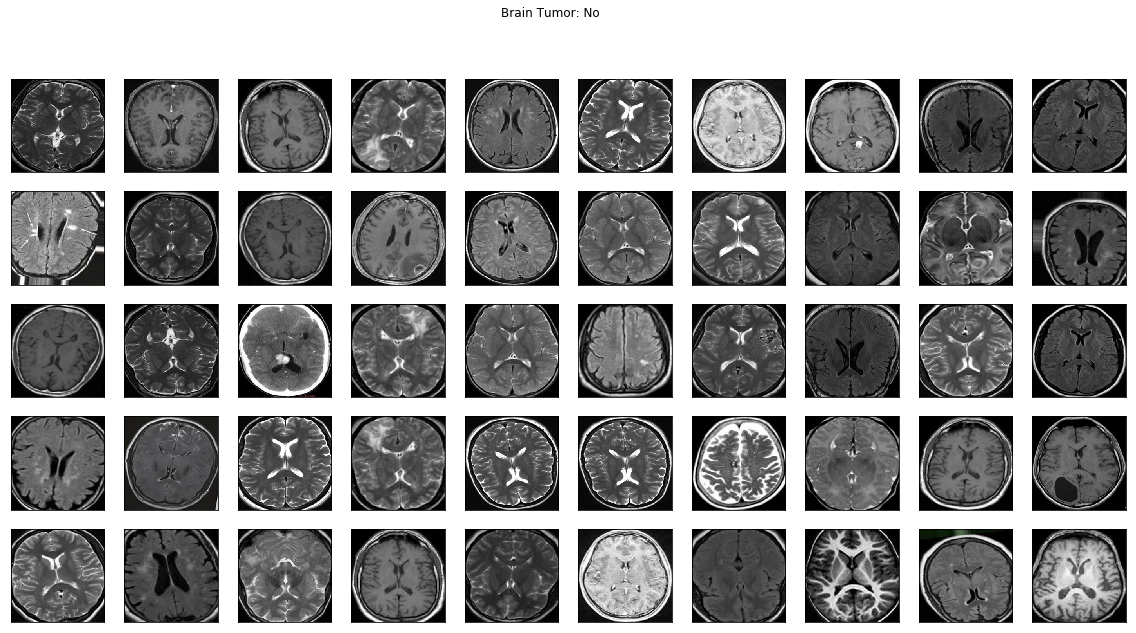

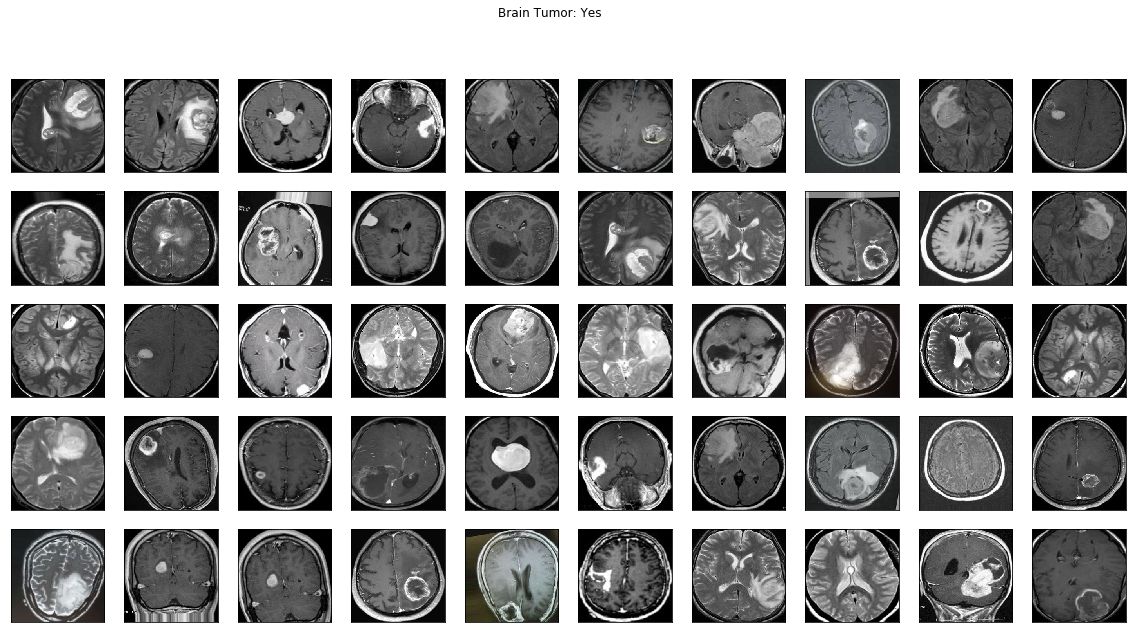

In [179]:
plot_sample_images(X, y)

In [180]:
def split_data(X,y, test_size=0.2):
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X,y ,test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [181]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X,y,test_size=0.3)


In [182]:
print("number of training examples = " + str(X_train.shape[0]))
print("number of development examples = " + str(X_val.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape:" + str(X_train.shape))
print("y_train shape:" + str(y_train.shape))
print("X_val (dev) shape:" + str(X_val.shape))
print("y_val (dev) shape:" + str(y_val.shape))
print("X_Test shape:" + str(X_test.shape))
print("Y_test shape:" + str(y_test.shape))

number of training examples = 1592
number of development examples = 342
number of test examples = 341
X_train shape:(1592, 240, 240, 3)
y_train shape:(1592, 1)
X_val (dev) shape:(342, 240, 240, 3)
y_val (dev) shape:(342, 1)
X_Test shape:(341, 240, 240, 3)
Y_test shape:(341, 1)


In [183]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed/(60*60))
    m = int((sec_elapsed % (60*60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"
    

In [184]:
def compute_f1_score(y_true, prob):
    #conver the vector of probabilities to a target vector
    y_pred = np.where(prob>0.5,1,0)
    
    score = f1_score(y_true, y_pred)
    
    return score 


In [185]:
def build_model(input_shape):
    
    # define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)
    X = ZeroPadding2D((2,2))(X_input)
    X = Conv2D(32,(7,7), strides =(1,1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    
    #maxpool
    X = MaxPooling2D((4,4), name='max_pool0')(X)
    
    #MAXPOOL
    X = MaxPooling2D((4,4), name='max_pool1')(X)
    
    #flatten X
    X = Flatten()(X)
    
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    model = Model(inputs= X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [186]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [187]:
model = build_model(IMG_SHAPE)

In [188]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [189]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [190]:
#tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')


In [193]:
#checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
#filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
#checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [195]:
#start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size = 32, epochs= 10, validation_data=(X_val, y_val))


#end_time = time.time()
#execution_time = (end_time - start_time)
#print(f"Elapsed time: {hms_string(execution_time)}")


Train on 1592 samples, validate on 342 samples
Epoch 1/10
1592/1592 [==============================] - 90s 57ms/sample - loss: 0.3945 - accuracy: 0.8185 - val_loss: 0.5361 - val_accuracy: 0.8012
Epoch 2/10
1592/1592 [==============================] - 90s 57ms/sample - loss: 0.3708 - accuracy: 0.8405 - val_loss: 0.4906 - val_accuracy: 0.8070
Epoch 3/10
1592/1592 [==============================] - 82s 52ms/sample - loss: 0.3625 - accuracy: 0.8392 - val_loss: 0.6129 - val_accuracy: 0.6667
Epoch 4/10
1592/1592 [==============================] - 83s 52ms/sample - loss: 0.3022 - accuracy: 0.8781 - val_loss: 0.4402 - val_accuracy: 0.8187
Epoch 5/10
1592/1592 [==============================] - 82s 52ms/sample - loss: 0.2844 - accuracy: 0.8788 - val_loss: 0.4813 - val_accuracy: 0.7778
Epoch 6/10
1592/1592 [==============================] - 82s 52ms/sample - loss: 0.2335 - accuracy: 0.9095 - val_loss: 0.4316 - val_accuracy: 0.8158
Epoch 7/10
1592/1592 [==============================] - 82s 52ms/

In [196]:
history = model.history.history


In [197]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [200]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    #loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    #accruacy
    plt.figure()
    plt.plot(train_acc, label='Training accuracy')
    plt.plot(val_acc, label='validation accuracy')
    plt.title('accuracy')
    plt.legend()
    plt.show()

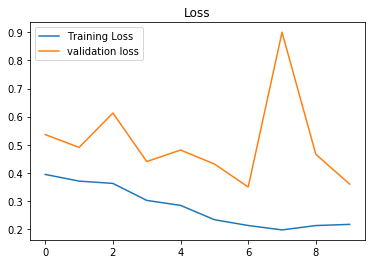

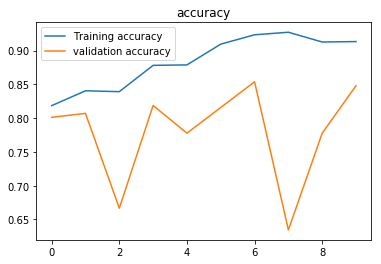

In [201]:
plot_metrics(history)